In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## define a fixed samplerate

In [2]:
samplerate=200

## load mass

In [3]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [4]:
annotations.head()

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,889.210080,177714,177842
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,906.577851,181200,181316
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,918.820873,183595,183764
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,923.198730,184464,184640
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,940.054908,187859,188011


In [5]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## define a fixed feature selection to use

In [6]:
featureSelection=loadPickle("EXT_F1_iteration_7.pkl")
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


## data splits definition
leave-one-subject-out CROSS VALIDATION

In [7]:
#define subjects used in the experiment
usedSubjects=np.array(signalsMetadata['subjectId'])
usedSubjects

array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
       '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016',
       '0017', '0018', '0019'], dtype=object)

In [8]:
valCount=2  #number of signals for validation (selected randomly)

trainSplits=[]
valSplits=[]
testSplits=[]
for i in range(len(usedSubjects)):
    thisTest=usedSubjects[i]
    thisNoTest=np.setdiff1d(usedSubjects,thisTest)
    thisVal=np.random.choice(thisNoTest,size=valCount,replace=False)
    thisTrain=np.setdiff1d(thisNoTest,thisVal)
    trainSplits.append(thisTrain)
    valSplits.append(thisVal)
    testSplits.append(thisTest)

dataSplits=pd.DataFrame({
    'train':trainSplits,
    'val':valSplits,
    'test':testSplits
})

dataSplits

,train,val,test
0,"[0002, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0011, 0015]",0001
1,"[0001, 0003, 0004, 0005, 0007, 0008, 0009, 001...","[0006, 0018]",0002
2,"[0001, 0004, 0005, 0006, 0007, 0008, 0009, 001...","[0002, 0016]",0003
3,"[0001, 0002, 0003, 0005, 0006, 0008, 0009, 001...","[0014, 0007]",0004
4,"[0001, 0002, 0003, 0004, 0006, 0007, 0008, 001...","[0012, 0009]",0005
5,"[0001, 0002, 0003, 0004, 0007, 0008, 0009, 001...","[0005, 0017]",0006
6,"[0001, 0004, 0005, 0006, 0008, 0009, 0010, 001...","[0002, 0003]",0007
7,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0014, 0016]",0008
8,"[0001, 0002, 0003, 0004, 0005, 0006, 0008, 001...","[0007, 0016]",0009
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0012, 0016]",0010


## define annotation criterium
by now we keep the labeler that went trough all the signals

In [9]:
#usedAnnotations=annotations[(annotations['type']=='spindle')&(annotations['labelerId']=='0001')]
usedAnnotations=annotations[(annotations['type']=='spindle')]

In [10]:
usedAnnotations[['subjectId','labelerId','duration']].groupby(['subjectId','labelerId']).describe()

duration                                          \
                       count      mean       std       min       25%   
subjectId labelerId                                                    
0001      0001        1044.0  0.822037  0.202792  0.390602  0.675735   
          0002        2452.0  1.186387  0.501335  0.238266  0.828072   
0002      0001        1143.0  0.834582  0.195713  0.414040  0.699173   
          0002        2212.0  1.220152  0.476991  0.171864  0.859320   
0003      0001         143.0  0.690269  0.149652  0.460907  0.585900   
          0002         602.0  0.960720  0.394157  0.222642  0.683550   
0004      0001         253.0  0.829708  0.224842  0.492157  0.667923   
0005      0001         341.0  0.706104  0.131805  0.425751  0.613243   
          0002        1201.0  0.916391  0.369363  0.175770  0.644490   
0006      0001         150.0  0.761306  0.143614  0.492157  0.679642   
          0002         840.0  0.943769  0.803034  0.171864  0.621054   
0007      0001         912.0  0.892692  0.226504  0.425751  0.730423   
          0002        1607.0  1.329647  0.597753  0.210924  0.890568   
0008      0001         385.0  0.846882  0.227884  0.441376  0.695267   
0009      0001         814.0  0.923970  0.216783  0.468719  0.773392   
          0002        1670.0  1.331134  0.697020  0.124992  0.890568   
0010      0001         795.0  0.815081  0.190663  0.402321  0.687454   
          0002        1939.0  1.198302  0.522212  0.148428  0.800730   
0011      0001         606.0  0.923982  0.222469  0.503876  0.773384   
          0002        1541.0  1.255826  0.592408  0.199206  0.792918   
0012      0001         709.0  0.836528  0.180787  0.437469  0.706985   
          0002        1204.0  1.226750  0.619745  0.199206  0.768506   
0013      0001         698.0  0.910960  0.245084  0.437477  0.742142   
          0002        1438.0  1.563736  0.769295  0.199206  1.008725   
0014      0001         713.0  0.805534  0.205166  0.406227  0.671829   
          0002        1618.0  1.261824  0.633302  0.199206  0.789988   
0015      0001          97.0  0.739281  0.106173  0.519501  0.671829   
0016      0001         452.0  0.806943  0.210937  0.335915  0.640587   
0017      0001         470.0  0.802766  0.155081  0.437469  0.694296   
          0002        1192.0  1.318288  0.513640  0.265608  0.949158   
0018      0001        1164.0  0.844465  0.185415  0.421852  0.722610   
          0002        1680.0  0.982301  0.425326  0.117180  0.667926   
0019      0001         315.0  0.770511  0.129903  0.453094  0.687454   
          0002        1058.0  1.044091  0.445582  0.195300  0.710892   

                                                    
                          50%       75%        max  
subjectId labelerId                                 
0001      0001       0.796822  0.945251   1.839722  
          0002       1.128834  1.484280   3.706794  
0002      0001       0.816353  0.937439   1.820198  
          0002       1.187424  1.542870   3.355254  
0003      0001       0.648399  0.775341   1.160080  
          0002       0.890568  1.177659   2.671704  
0004      0001       0.785103  0.945251   1.675674  
0005      0001       0.699173  0.781197   1.195236  
          0002       0.863226  1.124928   2.519370  
0006      0001       0.749954  0.847603   1.480377  
          0002       0.835884  1.128834  20.764296  
0007      0001       0.867134  1.003845   2.042839  
          0002       1.238202  1.718640   3.706794  
0008      0001       0.800728  0.937439   1.925659  
0009      0001       0.890568  1.027275   1.882690  
          0002       1.246014  1.683486  14.018634  
0010      0001       0.773392  0.921814   1.847542  
          0002       1.113210  1.511622   3.265416  
0011      0001       0.890564  1.042900   2.015495  
          0002       1.163988  1.605366   3.796632  
0012      0001       0.808548  0.956970   1.495995  
          0002       1.136646  1.558494   4.804380  
0013      0001       0.871036 

## load model

In [11]:
xgb_model=xgb.XGBClassifier()
xgb_model.load_model("generalModel_DREAMS")


## model testing

In [22]:
n_jobs=6 # paralelization parameter for xgboost (keep it 8 as maximum)

valF1s=[]
for index, row in dataSplits.iterrows():
    #Features
    valFeatures=loadFeatureMatrix(row.val,featureSelection,signalsMetadata,samplerate,datapath)
    #Labels
    valLabels=loadLabelsVector(row.val,usedAnnotations,signalsMetadata,samplerate)
    #val predictions and objective function definition
    valPredictions=xgb_model.predict(valFeatures)
    valF1s.append(F1(valLabels,valPredictions))
    break

""" dataSplits["model"]=xgb_model
dataSplits["treeLimit"]=xgb_model.best_ntree_limit
dataSplits["valF1"]=valF1s """


' dataSplits["model"]=xgb_model\ndataSplits["treeLimit"]=xgb_model.best_ntree_limit\ndataSplits["valF1"]=valF1s '

In [23]:
dataSplits

,train,val,test,model,treeLimit,valF1
0,"[0002, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0011, 0015]",0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.509842
1,"[0001, 0003, 0004, 0005, 0007, 0008, 0009, 001...","[0006, 0018]",0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.247324
2,"[0001, 0004, 0005, 0006, 0007, 0008, 0009, 001...","[0002, 0016]",0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.498447
3,"[0001, 0002, 0003, 0005, 0006, 0008, 0009, 001...","[0014, 0007]",0004,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.305899
4,"[0001, 0002, 0003, 0004, 0006, 0007, 0008, 001...","[0012, 0009]",0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.274968
5,"[0001, 0002, 0003, 0004, 0007, 0008, 0009, 001...","[0005, 0017]",0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.152976
6,"[0001, 0004, 0005, 0006, 0008, 0009, 0010, 001...","[0002, 0003]",0007,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.531203
7,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0014, 0016]",0008,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.297930
8,"[0001, 0002, 0003, 0004, 0005, 0006, 0008, 001...","[0007, 0016]",0009,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.236040
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0012, 0016]",0010,"XGBClassifier(base_score=0.5, booster='gbtree'...",44,0.217455


In [24]:
def labelingProcess(labelVector,maxTimeClose,minDuration,samplerate):
    aux=ndi.label(labelVector)
    preCandidates=ndi.find_objects(aux[0])
    if len(preCandidates)>0:    #consider the case of no precandidates at all
        #1. Join candidates separated by less than the threshold
        kernelLength=int(maxTimeClose*samplerate)
        if kernelLength>0:
            kernel=np.ones((kernelLength,))
            labelVector=ndi.binary_closing(labelVector,kernel)
        #2. Discard candidates under minimum duration
        aux=ndi.label(labelVector)
        candidates=ndi.find_objects(aux[0])
        labelVector=np.zeros_like(labelVector)
        if len(candidates)>0:
            durations=np.apply_along_axis(lambda x: (x[0].stop-x[0].start)/samplerate,1,candidates)
            detections=[candidates[i] for i in np.where(durations>minDuration)[0]]
            for detection in detections:
                labelVector[detection]=1
    return labelVector

In [75]:
valPredProcess=labelingProcess(valPredictions,0.1,0.6,samplerate)

In [76]:
aux=ndi.label(valPredProcess)
aux=ndi.find_objects(aux[0])
durations=np.apply_along_axis(lambda x: (x[0].stop-x[0].start)/samplerate,1,aux)
len(aux)

2572

In [77]:
max(durations)

5.06

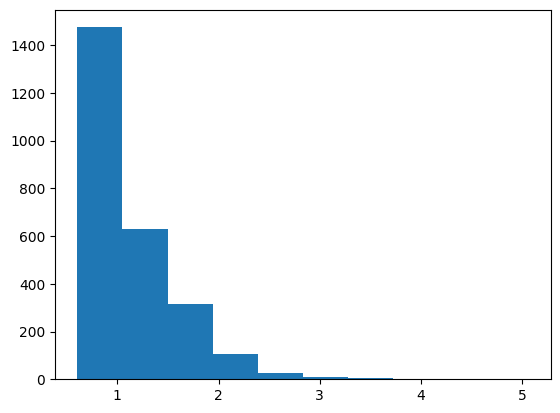

In [78]:
plt.hist(durations)
plt.show()

In [79]:
aux=ndi.label(valLabels)
aux=ndi.find_objects(aux[0])
len(aux)

1643

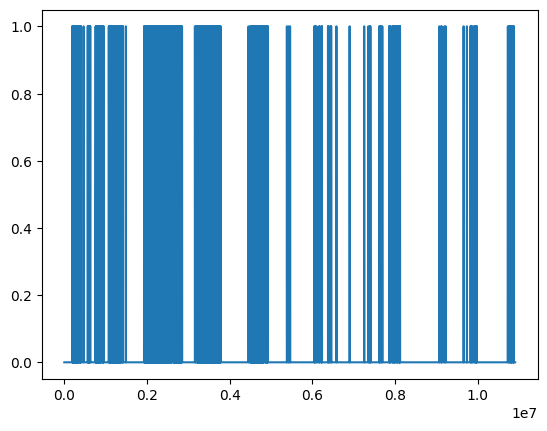

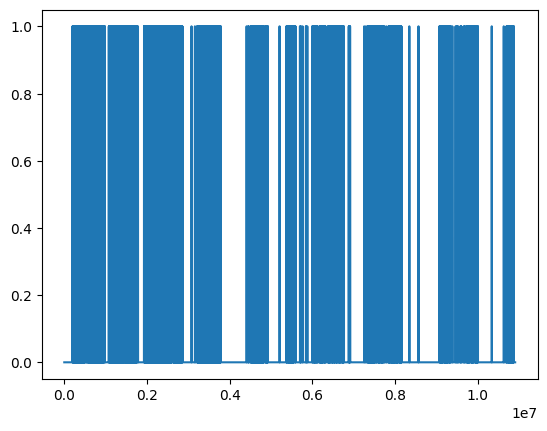

In [80]:
plt.plot(valLabels)
plt.show()
plt.plot(valPredProcess)
plt.show()

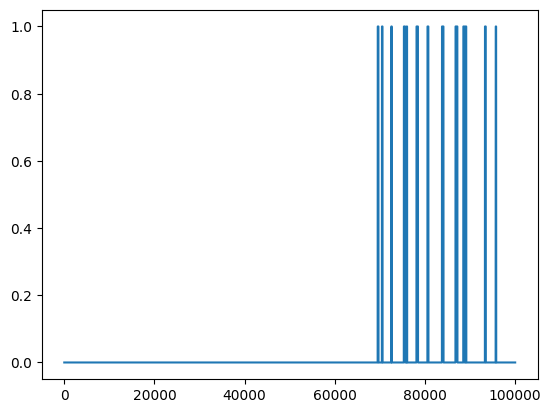

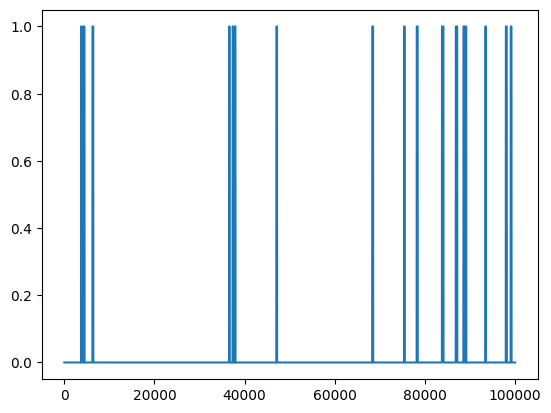

In [81]:
thisStart=500000
thisStop=600000
plt.plot(valLabels[thisStart:thisStop])
plt.show()
plt.plot(valPredProcess[thisStart:thisStop])
plt.show()

In [82]:
import sklearn.metrics as mt
mt.log_loss(valLabels,valPredictions)

1.9129069745709175

In [83]:
mt.log_loss(valLabels,valPredProcess)

1.0620217831658947

In [84]:
F1(valLabels,valPredictions)

0.5098415567369011

In [85]:
F1(valLabels,valPredProcess)

0.6562934820252095

In [86]:
MCC(valLabels,valPredProcess)

0.6510024543742404